Tras haber obtenido una aproximación de los mejores hiperparámetros para el genético con las métricas `internal_density` y `flake_odf`, hacemos las ejecuciones completas, evaluamos las soluciones contra las comunidades reales, y vemos qué zonas del Pareto obtienen mejores resultados.

In [1]:
%cd ..

/Users/pablomirallesgonzalez/Documents/masters-degree/Análisis de Redes Sociales/sna-ceb-assignment


In [2]:
import sys
sys.path.append('src')

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import functools
import random

from networkx import community as nxcom
from cdlib import NodeClustering
from cdlib.evaluation import internal_edge_density, normalized_mutual_information

from genetic_algs import NSGA2, tournament_select, random_locus_crossover, mutate_locus, mutate_locus_join, mutate_locus_separate, mutate_combine, create_locus
from disjoint_set_union import DisjointSetUnion
from metrics import avg_odf

## Carga de datos

Leemos el grafo, y preparamos unas estructuras de datos para pasar de etiquetas a índices, es decir, que el nodo i-ésimo se pueda identificar con el índice $i$ y con su etiqueta (e.g. `"1234"`) fácilmente.

In [5]:
GRAPH_FILE = "data/amazon_graph.graphml"
graph = nx.read_graphml(GRAPH_FILE)

In [6]:
nodes = list(graph.nodes())
node_to_idx = {node: idx for idx, node in enumerate(nodes)}
idx_to_node = {idx: node for idx, node in enumerate(nodes)}

edges: list[list[int]] = [
    list(set([ node_to_idx[neighbour] for neighbour in graph.neighbors(idx_to_node[idx]) ] + [idx]))
    for idx in range(graph.number_of_nodes())
]

## Código auxiliar

In [4]:
def community_list_to_dict(communities: list[list[int]]) -> dict[int, int]:
    # list of list of nodes in the same community to dict of node to community
    return {
        node: ind
        for ind, community in enumerate(communities)
        for node in community
    }

def community_dict_to_list(community_dict: dict[int, int]) -> list[list[int]]:
    # dict of node to community to list of list of nodes in the same community
    num_communities = max(community_dict.values()) + 1
    communities = [[] for _ in range(num_communities)]
    for node, community in community_dict.items():
        communities[community].append(node)
    return communities

In [8]:
def individual_to_communities(individual: list[int]) -> list[list[int]]:
    """
    Given an individual of the genetic algorithm, return the communities it represents,
    with the original labels in the graph.
    """
    dsu = DisjointSetUnion(len(individual))
    for i1, i2 in enumerate(individual):
        dsu.join(i1, i2)
    components = dsu.get_components()
    communities = [[idx_to_node[idx] for idx in component] for component in components]
    return communities

Código para dibujar gráficos:

In [84]:
def get_pareto_front_idx(fitness_values: list[tuple[float, float]]) -> list[tuple[float, float]]:
    indices = sorted(
        range(len(fitness_values)),
        key=lambda idx: fitness_values[idx],
        reverse=True,
    )
    max_f2 = float("-inf")
    non_dominated = []
    for idx in indices:
        _, f2 = fitness_values[idx]
        if f2 <= max_f2:
            continue
        non_dominated.append(idx)
        max_f2 = f2
    return non_dominated

def plot_metric_on_pareto_front(
    ranked_population: list[tuple[int, tuple[float, float], list[int]]],
    metric: callable,
    metric_name: str,
):
    pareto_front_idx = get_pareto_front_idx([fitness for _, fitness, _ in ranked_population])

    metrics = []
    for idx in pareto_front_idx:
        _, fitness, individual = ranked_population[idx]
        communities = individual_to_communities(individual)
        metrics.append((*fitness, metric(communities)))

    metrics = np.array(metrics)
    # create two plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: avg_odf vs internal_density, with nmi as hue
    ax1.scatter(metrics[:, 0], metrics[:, 1], c=metrics[:, 2])
    ax1.set_xlabel("avg_odf")
    ax1.set_ylabel("internal_density")
    ax1.set_title(f"Pareto front with {metric_name} as hue")
    fig.colorbar(ax1.collections[0], ax=ax1)

    # Plot 2: barplot, x-axis is the order of the individual in the pareto front, y-axis is the nmi
    # apply cmap to the bars
    normalize = lambda x: (x - x.min()) / (x.max() - x.min())
    colors = plt.colormaps.get_cmap("viridis")(normalize(metrics[:, 2]))
    ax2.bar(range(len(metrics)), metrics[:, 2], color=colors)
    ax2.set_xlabel("Pareto, from larger avg_odf (left) to larger internal_density (right)")
    ax2.set_ylabel(metric_name)
    ax2.set_title(f"{metric_name} of individuals in the pareto front")

## Algoritmo evolutivo

Respecto a las métricas, usaré la modularidad y otra que esté correlacionada negativamente. En particular, para la última probaré con la densidad y la fracción media de 

In [7]:
# unify metrics interface, so we can pass this as parameters
modularity_metric = lambda communities: nxcom.modularity(graph, communities)
internal_density_metric = lambda communities: internal_edge_density(graph, NodeClustering(communities, graph)).score
avg_odf_metric = lambda communities: 1. - avg_odf(graph, NodeClustering(communities, graph))

str_to_metric = {
    "modularity": modularity_metric,
    "avg_odf": avg_odf_metric,
    "internal_density": internal_density_metric,
}

In [9]:
BUDGET_FITNESS_CALLS = 50_000

def run(
    population_size: int,
    pcross: float,
    pmut: float,
    mutate_ratio_random: float,
    mutate_ratio_join: float,
    mutate_ratio_separate: float,
    T: int,
    metric_1: str,
    metric_2: str,
    trace: int = 25,
):
    ngen = BUDGET_FITNESS_CALLS // population_size
    mutate_fn_1 = functools.partial(mutate_locus, edges, mutate_ratio_random)
    mutate_fn_2 = functools.partial(mutate_locus_join, edges, mutate_ratio_join)
    mutate_fn_3 = functools.partial(mutate_locus_separate, mutate_ratio_separate)
    mutate_fn = functools.partial(mutate_combine, [mutate_fn_1, mutate_fn_2, mutate_fn_3])
    select_fn = functools.partial(tournament_select, T)
    metric_1 = str_to_metric[metric_1]
    metric_2 = str_to_metric[metric_2]

    def fitness_fn(individual: list[int]) -> tuple[float, float]:
        communities = individual_to_communities(individual)
        return metric_1(communities), metric_2(communities)

    population = create_locus(edges, population_size)

    ga = NSGA2[list[int], tuple[float, float]](
        fitness_fn=fitness_fn,
        select_fn=select_fn,
        crossover_fn=random_locus_crossover,
        mutate_fn=mutate_fn,
        pcross=pcross,
        pmut=pmut,
    )

    population_with_fitness = ga.run(population, ngen=ngen, trace=trace)

    return population_with_fitness

## Evaluación con comunidades reales

In [10]:
real_communities_dict = {node: attr["community"] for node, attr in list(graph.nodes(data=True))}
real_communities = community_dict_to_list(real_communities_dict)

## Obtención de soluciones

In [54]:
# best params
population_size = 100
pcross = 1.
pmut = 0.1
mutate_ratio_random = 0.013153241551069672
mutate_ratio_join = 0.8360645142667775
mutate_ratio_separate = 0.029490919492801693
T = 8

random.seed(42)

ranked_population = run(
    population_size=population_size,
    pcross=pcross,
    pmut=pmut,
    mutate_ratio_random=mutate_ratio_random,
    mutate_ratio_join=mutate_ratio_join,
    mutate_ratio_separate=mutate_ratio_separate,
    T=T,
    metric_1="avg_odf",
    metric_2="internal_density",
    trace=25,
)

Generation 0 - std_dev_fitness=[0.06759312603888912, 0.026972903229811225]
		Best value for objective 0: (0.519751300439153, 0.49842277556499065)
		Best value for objective 1: (0.519751300439153, 0.49842277556499065)
Generation 25 - std_dev_fitness=[0.08168263532723267, 0.05438934945609436]
		Best value for objective 0: (0.8015479737373458, 0.5479763976680505)
		Best value for objective 1: (0.7058366759101175, 0.6308531940045596)
Generation 50 - std_dev_fitness=[0.09972293860267495, 0.04918412801825376]
		Best value for objective 0: (0.8838340630462099, 0.49154042744907034)
		Best value for objective 1: (0.7934996706719816, 0.6399996903268683)
Generation 75 - std_dev_fitness=[0.11967813109116887, 0.04900708036307708]
		Best value for objective 0: (0.9050863259989129, 0.5419939834174515)
		Best value for objective 1: (0.8368244785160261, 0.6445340104055619)
Generation 100 - std_dev_fitness=[0.12575971722062, 0.05318294211448882]
		Best value for objective 0: (0.9217407237315254, 0.55049

Obtenemos el frente de Pareto y lo dibujamos, junto con la información mutua respecto a las comunidades reales y el número de comunidades que se generan.

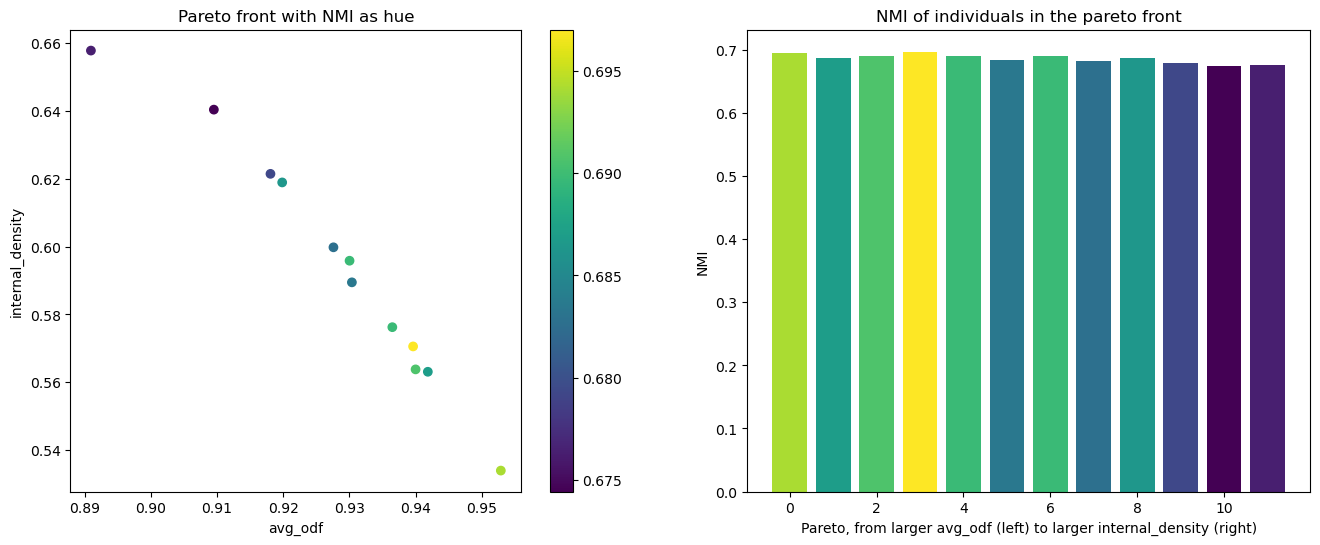

In [85]:
def nmi(communities: list[list[str]]) -> float:
    return normalized_mutual_information(
        NodeClustering(real_communities, graph),
        NodeClustering(communities, graph),
    ).score

plot_metric_on_pareto_front(ranked_population, nmi, "NMI")

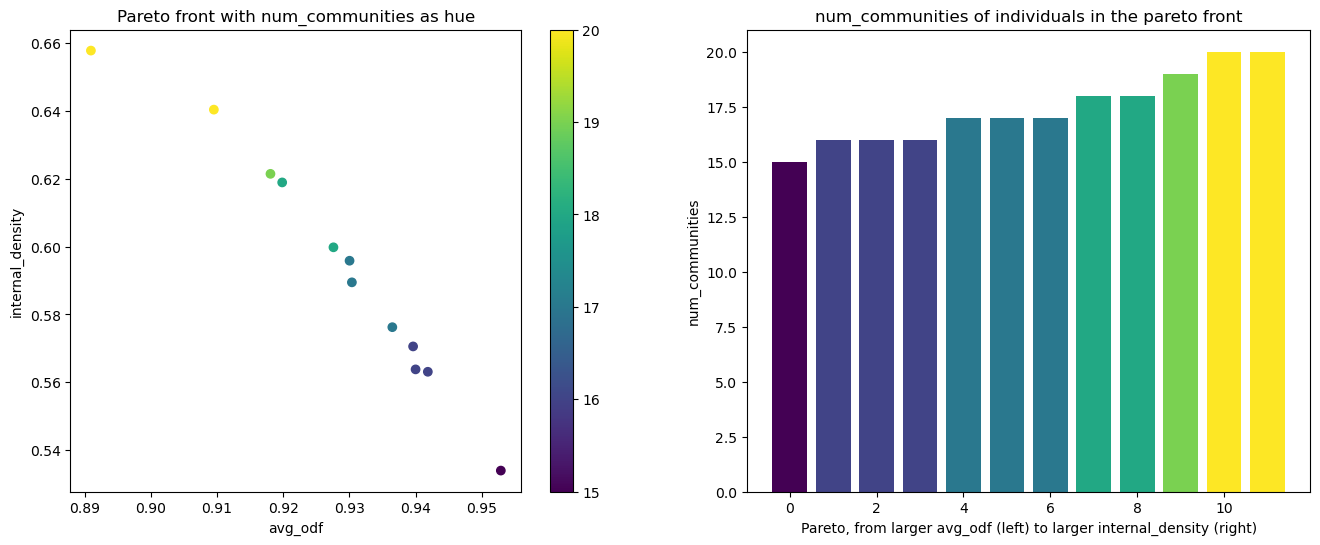

In [86]:
plot_metric_on_pareto_front(ranked_population, lambda communities: len(communities), "num_communities")

Vemos que cuanto más prioriza la fracción de nodos que apuntan fuera del clúster, más se parece a las comunidades reales.

In [87]:
best_solution = ranked_population[0][2]
best_nmi = nmi(individual_to_communities(best_solution))

metrics = []
for _, fitness, individual in ranked_population:
    communities = individual_to_communities(individual)
    nmi = normalized_mutual_information(
        NodeClustering(real_communities, graph),
        NodeClustering(communities, graph),
    ).score
    if nmi > best_nmi:
        best_nmi = nmi
        best_solution = individual
best_nmi

0.6970125438947856